In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2023-07-22T13:23:00.254308-06:00

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.12.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 6.2.0-25-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 6
Architecture: 64bit



In [3]:
ls ../

Hacking/  Jupyter/  README.md  Secciones/


In [4]:
import pandas as pd

In [5]:
vehiculos = pd.read_csv("/home/carlostr/curso_data_science-master/Secciones/Seccion4.Analisis_y_procesado_de_datos/Procesado_de_Datos/data/vehiculos_original.csv")

In [6]:
vehiculos = vehiculos.rename(columns={
    "make":"marca",
    "model":"modelo",
    "year":"year",
    "displ":"desplazamiento",
    "cylinders":"cilindros",
    "trany":"transmision",
    "drive":"traccion",
    "VClass":"clase",
    "fuelType":"combustible",
    "comb08":"consumo",
    "co2TailpipeGpm":"co2"}
)

In [7]:
vehiculos.head(5)

,marca,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
1,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
3,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500


In [10]:
vehiculos['modelo_unico']=vehiculos.marca.str.cat([vehiculos.modelo,vehiculos.year.apply(str)],sep='-') # marca-modelo-year

In [11]:
vehiculos.modelo_unico.value_counts() #vemos cuales valores estan repetidos

Jeep-Cherokee/Wagoneer-1985               24
Ford-F150 Pickup 2WD-1984                 19
GMC-C15 Pickup 2WD-1984                   19
Chevrolet-C10 Pickup 2WD-1984             19
GMC-C15 Pickup 2WD-1985                   18
                                          ..
Mercedes-Benz-C300-2015                    1
Mercedes-Benz-C300-2009                    1
Mercedes-Benz-C280 4matic-2007             1
Mercedes-Benz-C280 4matic-2006             1
smart-fortwo electric drive coupe-2016     1
Name: modelo_unico, Length: 17448, dtype: int64

In [12]:
vehiculos[vehiculos.duplicated()].shape #vemos cuantos duplicados hay

(1506, 12)

In [13]:
vehiculos = vehiculos.drop_duplicates()
vehiculos.shape

(36930, 12)

In [14]:
del vehiculos['modelo_unico']

In [15]:
df_co2 = vehiculos.sort_values(by='co2',ascending=False)

In [16]:
df_co2_top5 = df_co2.head(20).groupby("marca")["co2"].mean()

# Valores mas frecuentes

In [17]:
n_records=len(vehiculos) #para saber los valores mas frecuentes en cada columna
def valores_duplicados_col(df):
    for columna in df:
        n_por_valor = df[columna].value_counts()
        mas_comun = n_por_valor.iloc[0]
        menos_comun = n_por_valor.iloc[-1]
        print("{} | +{}, -{} | {}".format(
            df[columna].name,
            round(mas_comun/n_records,3),
            round(menos_comun/n_records,3),
            df[columna].dtype       
        ))
valores_duplicados_col(vehiculos)

marca | +0.1, -0.0 | object
modelo | +0.005, -0.0 | object
year | +0.038, -0.007 | int64
desplazamiento | +0.095, -0.0 | float64
cilindros | +0.38, -0.0 | float64
transmision | +0.287, -0.0 | object
traccion | +0.353, -0.005 | object
clase | +0.145, -0.0 | object
combustible | +0.652, -0.0 | object
consumo | +0.097, -0.0 | int64
co2 | +0.084, -0.0 | float64


In [18]:
vehiculos.traccion.value_counts(normalize=True) #Esta funcion nos entrega como esta distribuida la traccion por
#porcentaje en el dataset

Front-Wheel Drive             0.360280
Rear-Wheel Drive              0.352863
4-Wheel or All-Wheel Drive    0.177345
All-Wheel Drive               0.062325
4-Wheel Drive                 0.030886
2-Wheel Drive                 0.011402
Part-time 4-Wheel Drive       0.004899
Name: traccion, dtype: float64

In [19]:
%matplotlib inline

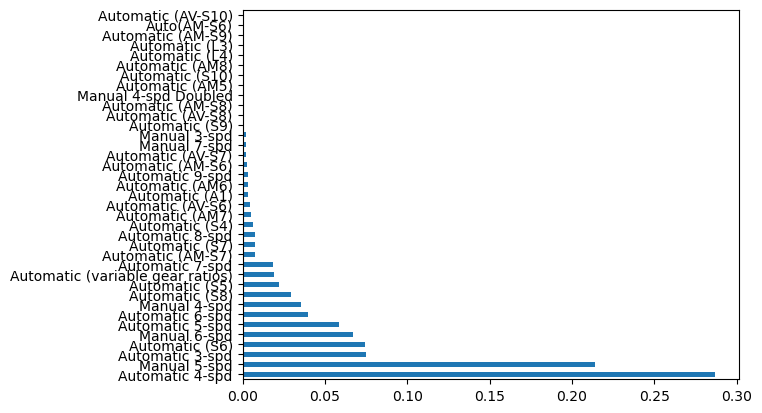

In [20]:
vehiculos.transmision.value_counts(normalize=True).plot.barh();

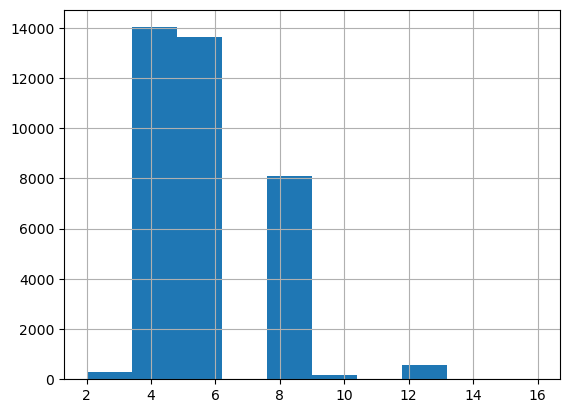

In [21]:
vehiculos.cilindros.hist();

<Axes: >

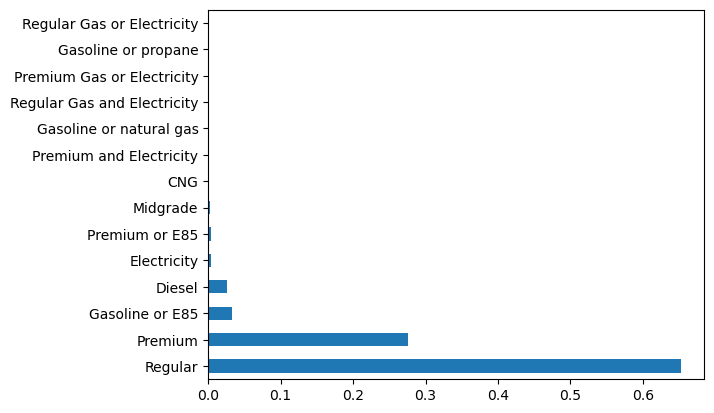

In [22]:
vehiculos.combustible.value_counts(normalize=True).plot.barh()

# Valores inexistentes

In [23]:
n_records = len(vehiculos)
def valores_inexistentes_col(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name,
            len(df[df[column].isnull()])/n_records,
            df[column].dtype
        ))
valores_inexistentes_col(vehiculos)

marca | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 0.0037909558624424585 | float64
cilindros | 0.003845112374763065 | float64
transmision | 0.00029786081776333605 | object
traccion | 0.02158137015976171 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


# Valores extremos

z score:

$$z(x) = \frac{x-\mu}{\sigma}$$

In [24]:
from scipy import stats
import numpy as np

def outliers_col(df):
    for columna in df:
        if vehiculos[columna].dtype != np.object:
            n_outliers = len(vehiculos[np.abs(stats.zscore(vehiculos[columna]))>3])
            print("{} | {} | {}".format(
                df[columna].name,
                n_outliers,
                df[columna].dtype
            
            ))


outliers_col(vehiculos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 233 | int64
co2 | 358 | float64


/tmp/ipykernel_6121/2763098259.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if vehiculos[columna].dtype != np.object:


<Axes: >

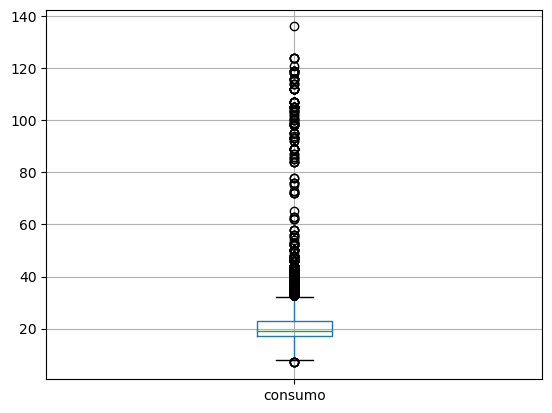

In [35]:
vehiculos.boxplot(column='consumo')

<Axes: >

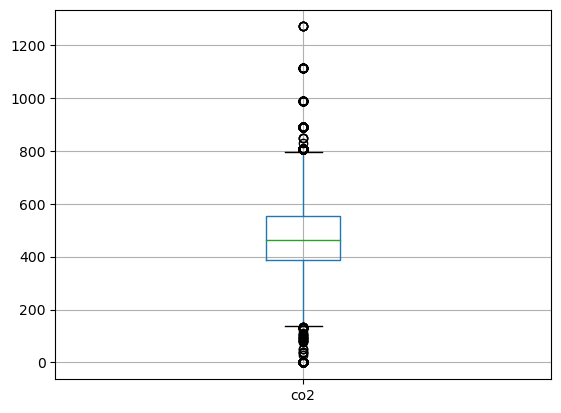

In [29]:
vehiculos.boxplot(column='co2') #Forma grafica de ver outliers

In [30]:
vehiculos_no_electricos = vehiculos[vehiculos.co2>0]

In [31]:
vehiculos[vehiculos.co2==0].combustible.unique()

array(['Electricity'], dtype=object)

In [32]:
vehiculos[vehiculos.co2!=0].combustible.unique()

array(['Regular', 'Premium', 'Diesel', 'Premium and Electricity',
       'Premium or E85', 'Premium Gas or Electricity', 'Gasoline or E85',
       'Gasoline or natural gas', 'CNG', 'Regular Gas or Electricity',
       'Midgrade', 'Regular Gas and Electricity', 'Gasoline or propane'],
      dtype=object)

In [33]:
vehiculos_no_electricos.to_csv("/home/carlostr/curso_data_science-master/Secciones/Seccion4.Analisis_y_procesado_de_datos/Procesado_de_Datos/data/vehiculos.2.limpio_analisis")

In [34]:
vehiculos_no_electricos.shape

(36791, 11)

Vemos que variables podemos agrupar (las que tengan menos categorias)

In [36]:
#funcion que cuenta los valores unicos de cada columna
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name,len(df[column].unique()),df[column].dtype
        ))
unique_col_values(vehiculos_no_electricos)

marca | 129 | object
modelo | 3734 | object
year | 35 | int64
desplazamiento | 66 | float64
cilindros | 10 | float64
transmision | 38 | object
traccion | 8 | object
clase | 34 | object
combustible | 13 | object
consumo | 49 | int64
co2 | 596 | float64


# Agrupamos los coches por sus caracteristicas


In [37]:
vehiculos_no_electricos.clase.unique()

array(['Special Purpose Vehicle 2WD', 'Midsize Cars', 'Subcompact Cars',
       'Compact Cars', 'Sport Utility Vehicle - 4WD',
       'Small Sport Utility Vehicle 2WD',
       'Small Sport Utility Vehicle 4WD', 'Two Seaters',
       'Sport Utility Vehicle - 2WD', 'Special Purpose Vehicles',
       'Special Purpose Vehicle 4WD', 'Small Station Wagons',
       'Minicompact Cars', 'Midsize-Large Station Wagons',
       'Midsize Station Wagons', 'Large Cars',
       'Standard Sport Utility Vehicle 4WD',
       'Standard Sport Utility Vehicle 2WD', 'Minivan - 4WD',
       'Minivan - 2WD', 'Vans', 'Vans, Cargo Type',
       'Vans, Passenger Type', 'Standard Pickup Trucks 2WD',
       'Standard Pickup Trucks', 'Standard Pickup Trucks/2wd',
       'Small Pickup Trucks 2WD', 'Standard Pickup Trucks 4WD',
       'Small Pickup Trucks 4WD', 'Small Pickup Trucks', 'Vans Passenger',
       'Special Purpose Vehicle', 'Special Purpose Vehicles/2wd',
       'Special Purpose Vehicles/4wd'], dtype=object

Por tamano

In [38]:
pequeno = ['Compact Cars','Subcompact Cars','Two Seaters','Minicompact Cars']
medio = ['Midsize Cars']
grande = ['Large Cars']

vehiculos.loc[vehiculos['clase'].isin(pequeno), 
             'clase_tipo'] = 'Coches pequeños'

vehiculos.loc[vehiculos['clase'].isin(medio), 
             'clase_tipo'] = 'Coches Medianos'

vehiculos.loc[vehiculos['clase'].isin(grande), 
             'clase_tipo'] = 'Coches Grandes'

vehiculos.loc[vehiculos['clase'].str.contains('Truck'), 
             'clase_tipo'] = 'Camionetas'

vehiculos.loc[vehiculos['clase'].str.contains('Special Purpose'), 
             'clase_tipo'] = 'Vehículos Especiales'

vehiculos.loc[vehiculos['clase'].str.contains('Sport Utility'), 
             'clase_tipo'] = 'Deportivos'

vehiculos.loc[vehiculos['clase'].str.contains('Station'), 
             'clase_tipo'] = 'Coche Familiar'

vehiculos.loc[(vehiculos['clase'].str.lower().str.contains('van')),
             'clase_tipo'] = 'Furgoneta'

In [39]:
vehiculos.clase_tipo = vehiculos.clase_tipo.astype("category")

In [40]:
vehiculos.clase_tipo.value_counts()

Coches pequeños         13055
Camionetas               5446
Deportivos               5313
Coches Medianos          4274
Coche Familiar           2540
Vehículos Especiales     2216
Furgoneta                2213
Coches Grandes           1873
Name: clase_tipo, dtype: int64

Por traccion

In [41]:
vehiculos.traccion.unique()

array(['2-Wheel Drive', 'Rear-Wheel Drive', 'Front-Wheel Drive',
       '4-Wheel or All-Wheel Drive', 'All-Wheel Drive', nan,
       '4-Wheel Drive', 'Part-time 4-Wheel Drive'], dtype=object)

In [42]:
vehiculos["traccion_tipo"] = "dos"
vehiculos["traccion_tipo"][vehiculos.traccion.isin([
    "4-Wheel or All-Wheel Drive", "All-Wheel Drive",
    "4-Wheel Drive", "Part-time 4-Wheel Drive"
])] = "cuatro"

/tmp/ipykernel_6121/3922553055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehiculos["traccion_tipo"][vehiculos.traccion.isin([


In [43]:
pd.set_option('chained_assignment',None) #deshabilitar el warning

In [44]:
vehiculos.traccion_tipo = vehiculos.traccion_tipo.astype("category")

Por transmision

In [45]:
vehiculos.transmision.unique()

array(['Automatic 3-spd', 'Automatic 4-spd', 'Manual 5-spd',
       'Automatic (S5)', 'Manual 6-spd', 'Automatic 5-spd',
       'Automatic (AM8)', 'Automatic (AM-S8)', 'Automatic (AV-S7)',
       'Automatic (S6)', 'Automatic (S9)', 'Automatic (AM-S7)',
       'Automatic (S4)', 'Automatic (AM-S9)', 'Automatic (S7)',
       'Automatic (AM7)', 'Automatic (AM6)', 'Automatic 6-spd',
       'Automatic 8-spd', 'Manual 4-spd', 'Automatic (S8)',
       'Manual 7-spd', 'Automatic (AM-S6)', 'Auto(AM-S6)',
       'Automatic (variable gear ratios)', 'Automatic (AV-S8)',
       'Automatic (A1)', 'Automatic (AV-S6)', 'Manual 3-spd',
       'Automatic (S10)', 'Automatic 9-spd', 'Manual 4-spd Doubled', nan,
       'Automatic (L4)', 'Automatic (L3)', 'Automatic (AV-S10)',
       'Automatic 7-spd', 'Automatic (AM5)'], dtype=object)

In [46]:
vehiculos['transmision_tipo'] = "Automatica"
vehiculos['transmision_tipo'][
    (vehiculos['transmision'].notnull()) & (vehiculos['transmision'].str.startswith('M'))
] = "Manual"

In [47]:
vehiculos.transmision_tipo = vehiculos.transmision_tipo.astype("category")

In [48]:
vehiculos.transmision_tipo.value_counts()

Automatica    25076
Manual        11854
Name: transmision_tipo, dtype: int64

Combustible

In [49]:
vehiculos.combustible.value_counts()

Regular                        24078
Premium                        10206
Gasoline or E85                 1215
Diesel                           933
Electricity                      139
Premium or E85                   124
Midgrade                          77
CNG                               60
Premium and Electricity           30
Gasoline or natural gas           20
Regular Gas and Electricity       20
Premium Gas or Electricity        18
Gasoline or propane                8
Regular Gas or Electricity         2
Name: combustible, dtype: int64

In [50]:
vehiculos['combustible_tipo'] = 'Otros tipos de combustible'
vehiculos.loc[vehiculos['combustible']=='Regular',
             'combustible_tipo'] = 'Normal'
vehiculos.loc[vehiculos['combustible']=='Premium',
             'combustible_tipo'] = 'Premium'

vehiculos.loc[vehiculos['combustible'].str.contains('Electricity'),
             'combustible_tipo'] = 'Hibrido'

In [51]:
vehiculos.combustible_tipo = vehiculos.combustible_tipo.astype("category")

In [52]:
vehiculos.combustible_tipo.value_counts()

Normal                        24078
Premium                       10206
Otros tipos de combustible     2437
Hibrido                         209
Name: combustible_tipo, dtype: int64

In [53]:
vehiculos.head()

,marca,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,Vehículos Especiales,dos,Automatica,Normal
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,Vehículos Especiales,dos,Automatica,Normal
5,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal
6,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500,Coches Medianos,dos,Automatica,Premium


# Agrupar variables continuas

Usando cuantiles podemos agrupar las variables continuas

In [54]:
tipos_tamaño_motor = ['muy pequeño',"pequeño",  "mediano", "grande", "muy grande"]

vehiculos['tamano_motor_tipo'] = pd.qcut(vehiculos['desplazamiento'],
                                  5, tipos_tamaño_motor)

In [55]:
tipos_consumo = ['muy bajo', 'bajo', 'moderado', 'alto', 'muy alto']

vehiculos['consumo_tipo'] = pd.qcut(vehiculos['consumo'],
                                  5, tipos_consumo)

In [56]:
tipos_co2 = ['muy bajo', 'bajo', 'moderado', 'alto', 'muy alto']

vehiculos['co2_tipo'] = pd.qcut(vehiculos['co2'],
                                  5, tipos_co2)

In [57]:
vehiculos.head()

,marca,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,bajo,alto
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy bajo,muy alto
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,muy bajo,alto
5,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy bajo,muy alto
6,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500,Coches Medianos,dos,Automatica,Premium,grande,muy bajo,alto


In [58]:
litros_por_galon =  3.78541

vehiculos["consumo_litros_milla"] = litros_por_galon/ vehiculos.consumo

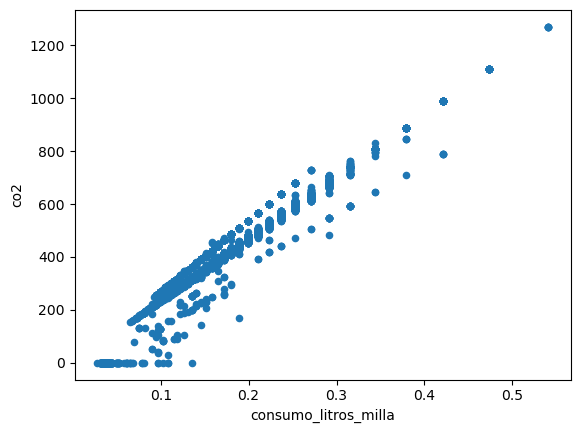

In [59]:
vehiculos.plot.scatter(x="consumo_litros_milla",y="co2");

In [60]:
tipos_consumo = ['muy bajo', 'bajo', 'moderado', 'alto', 'muy alto']

vehiculos['consumo_tipo'] = pd.qcut(vehiculos['consumo_litros_milla'],
                                  5, labels=tipos_consumo)

vehiculos.consumo_tipo.head()

0        alto
2    muy alto
4        alto
5    muy alto
6        alto
Name: consumo_tipo, dtype: category
Categories (5, object): ['muy bajo' < 'bajo' < 'moderado' < 'alto' < 'muy alto']

In [62]:
vehiculos.to_pickle("/home/carlostr/curso_data_science-master/Secciones/Seccion4.Analisis_y_procesado_de_datos/Procesado_de_Datos/data/vehiculos.3.variables_agrupadas.pkl")